In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import optuna

sys.path.append(os.path.abspath(os.path.join('..')))

from src.utils import load_data, evaluate_model, plot_roc, compare_models

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\Users\NIKHIL AGRAWAL\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_data('../data/raw/train_dataset.csv')
print(df.info())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

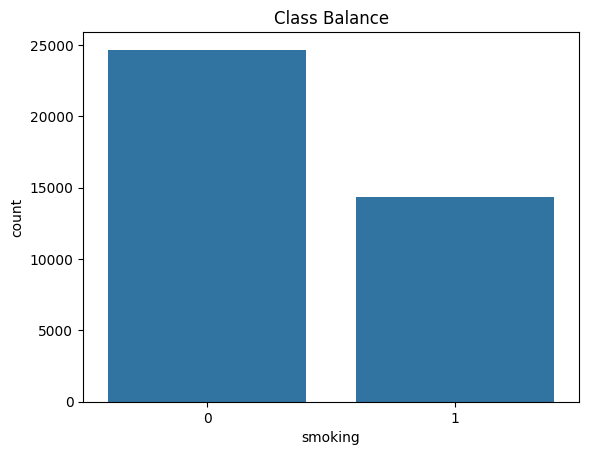

In [3]:
target = 'smoking'
sns.countplot(x=target, data=df)
plt.title('Class Balance')
plt.show()

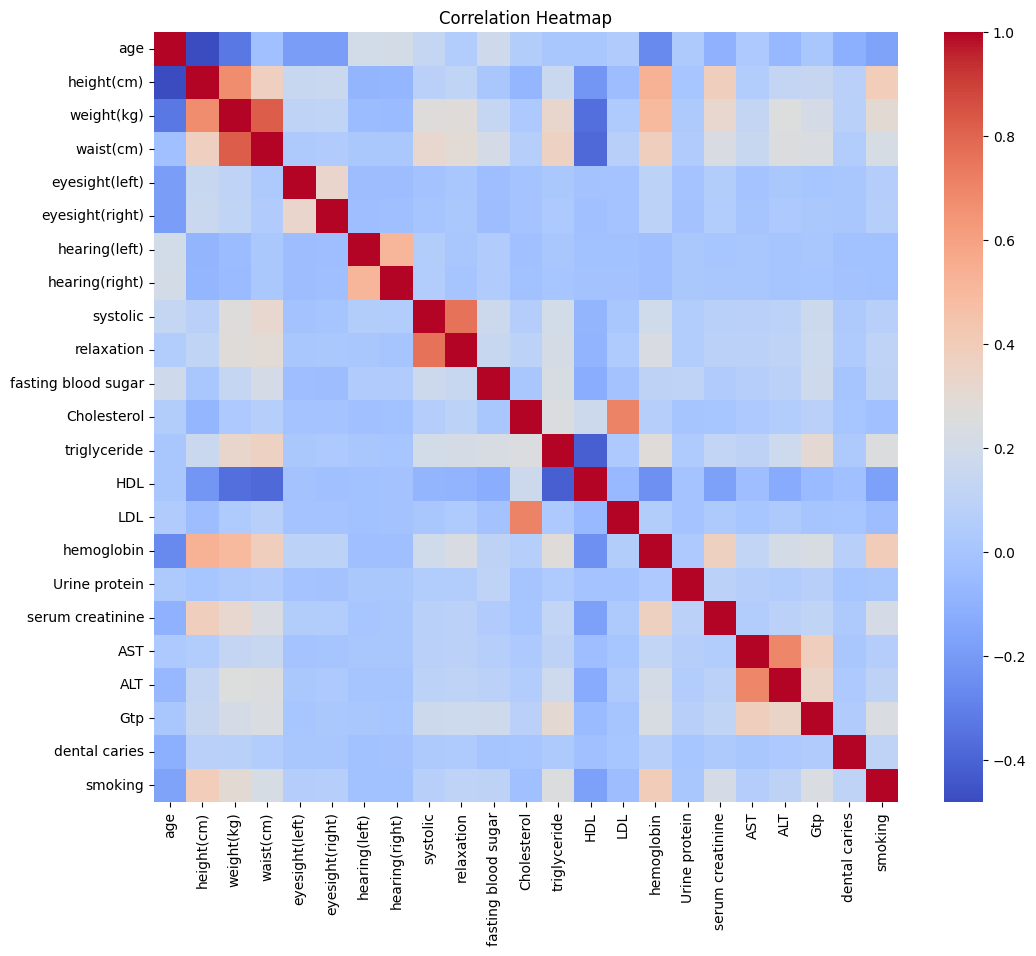

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
X = df.drop(target, axis=1)
y = df[target]

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Pre-transform X_train for Optuna efficiency
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Use a subset for faster tuning (e.g., 5000 samples)
tuning_size = min(5000, len(X_train_transformed))
idx_tune = np.random.choice(len(X_train_transformed), size=tuning_size, replace=False)
X_tune = X_train_transformed[idx_tune]
y_tune = y_train.iloc[idx_tune]

print(f"Tuning on subset of {tuning_size} samples...")

Tuning on subset of 5000 samples...


In [7]:
# === Optimization (Commented Out) ===
print("Skipping Tuning (Reverted to Default Models)")

# best_svm = SVC(**study.best_params...)
best_svm = SVC(probability=True, random_state=42)

# best_rf = RandomForestClassifier(**study_rf.best_params...)
best_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# best_knn = KNeighborsClassifier(**study_knn.best_params...)
best_knn = KNeighborsClassifier(n_jobs=-1)

Skipping Tuning (Reverted to Default Models)


Starting Training...
Training Logistic Regression...


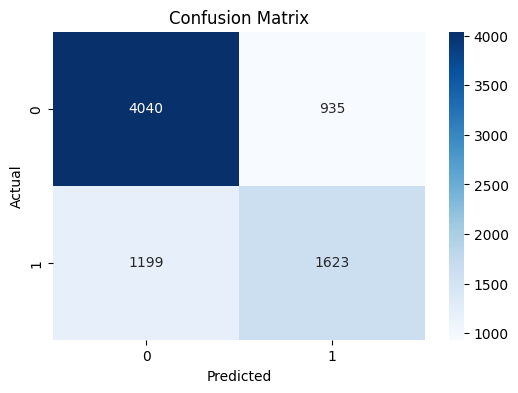

Training KNN...


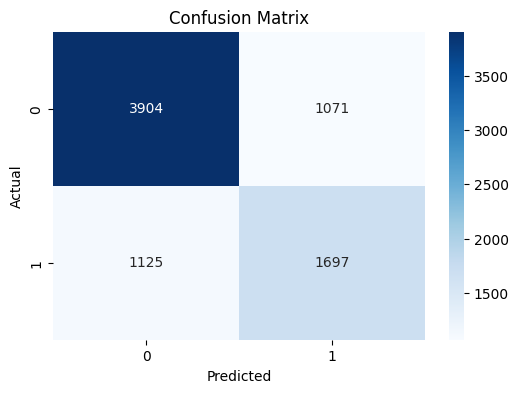

Training SVM...


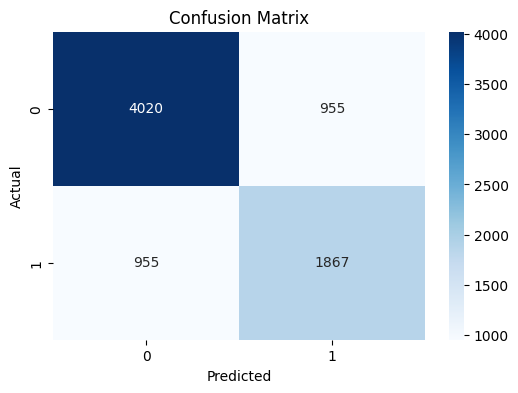

Training Naive Bayes...


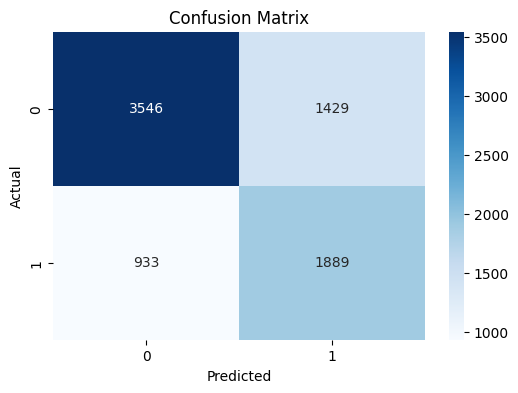

Training Decision Tree...


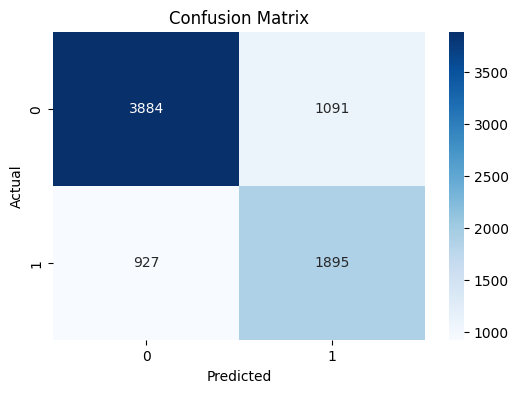

Training Random Forest...


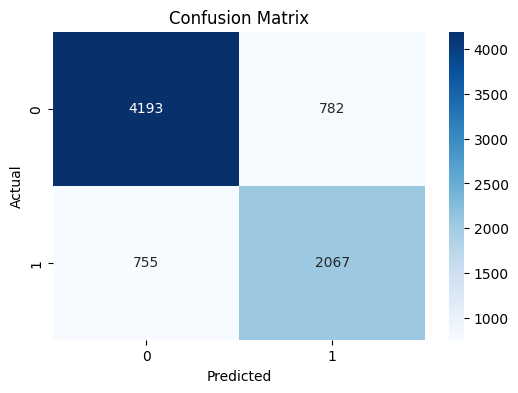

Training MLP...


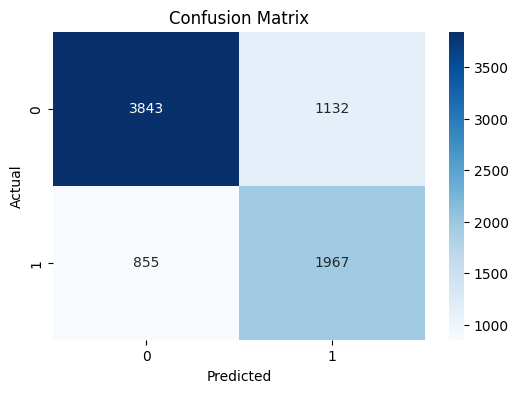

In [8]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': best_knn,
    'SVM': best_svm,
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': best_rf,
    'MLP': MLPClassifier(random_state=42, max_iter=500)
}

results = {}
trained_models = {}

print("Starting Training...")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_transformed, y_train)
    results[name] = evaluate_model(model, X_test_transformed, y_test)
    trained_models[name] = model

In [9]:
df_results = compare_models(results)
print(df_results)

                     Accuracy  Precision    Recall        F1
Random Forest        0.802873   0.725518  0.732459  0.728972
MLP                  0.745158   0.634721  0.697023  0.664415
SVM                  0.755034   0.661588  0.661588  0.661588
Decision Tree        0.741183   0.634628  0.671510  0.652548
Naive Bayes          0.697063   0.569319  0.669383  0.615309
KNN                  0.718353   0.613078  0.601347  0.607156
Logistic Regression  0.726305   0.634480  0.575124  0.603346


Plotting ROC for Best Model: Random Forest


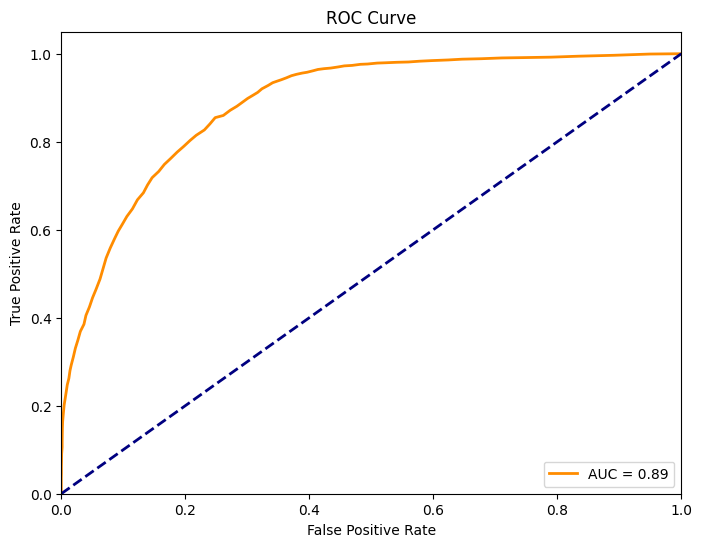

In [10]:
best_model_name = df_results.index[0]
best_model = trained_models[best_model_name]
print(f"Plotting ROC for Best Model: {best_model_name}")
plot_roc(best_model, X_test_transformed, y_test)

In [11]:
# === Generate Predictions for Test Dataset ===
print("\n--- Generating Predictions for submission ---")

# 1. Load the test CSV
test_df = load_data('../data/raw/test_dataset.csv')
print(f"Test set loaded: {test_df.shape}")

# 2. Preprocess using the SAME pipeline fitted on train data
X_submission_transformed = preprocessor.transform(test_df)

# 3. Predict using the best model found
# Note: The output is just an array of 0s and 1s
final_predictions = best_model.predict(X_submission_transformed)

# 4. Save to CSV
submission = pd.DataFrame({'prediction': final_predictions})
submission.to_csv('submission_smoker.csv', index=False)
print("Predictions saved to 'submission_smoker.csv'")
print(submission.head())


--- Generating Predictions for submission ---
Test set loaded: (16708, 22)
Predictions saved to 'submission_smoker.csv'
   prediction
0           1
1           1
2           0
3           0
4           0
